In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf

from tbpp_model import TBPP512
from tbpp_utils import PriorUtil
from utils.model_utils import load_weights
from utils.bboxes import rbox_to_polygon, polygon_to_rbox

from ssd_viz import plot_box

Using TensorFlow backend.


In [2]:
import pickle
from data_synthtext import GTUtility

file_name = 'gt_util_synthtext_seglink_xxs.pkl'
with open(file_name, 'rb') as f:
    gt_util = pickle.load(f)

In [3]:
_, inputs, images, data = gt_util.sample_random_batch(32)

test_idx = 0
test_input = inputs[test_idx]
test_img = images[test_idx]
test_gt = data[test_idx]

#plt.figure(figsize=[8]*2)
#plt.imshow(test_img)
#gt_util.plot_gt(test_gt, show_labels=False)
#plt.show()

In [4]:
model = TBPP512()
prior_util = PriorUtil(model)

In [5]:
layers = []

def calc_receptive_field(model, layer_name, verbose=False):
    """Calculate the receptive field related to a certain layer.
    
    # Arguments
        model: Keras model.
        layer_name: Name of the layer.
    
    # Return
        rf: Receptive field (w, h).
        es: Effictive stides in the input image.
        offset: Center of the receptive field associated with the first unit (x, y).
    """
    
    fstr = '%-20s %-16s %-10s %-10s %-10s %-16s %-10s %-16s'
    if verbose:
        print(fstr % ('name', 'type', 'kernel', 'stride', 'dilation', 'receptive field', 'offset', 'effective stride'))
    l = model.get_layer(layer_name)
    rf = np.ones(2)
    es = np.ones(2)
    offset = np.zeros(2)
    ep = np.zeros(2)
    
    while True:
        layers.append(l)
        layer_type = l.__class__.__name__
        k, s, d = (1,1), (1,1), (1,1)
        p = 'same'
        if layer_type in ['Conv2D']:
            k = l.kernel_size
            d = l.dilation_rate
            s = l.strides
            p = l.padding
        elif layer_type in ['MaxPooling2D', 'AveragePooling2D']:
            k = l.pool_size
            s = l.strides
            p = l.padding
        elif layer_type in ['ZeroPadding2D']:
            p = l.padding
        elif layer_type in ['InputLayer', 'Activation', 'BatchNormalization']:
            pass
        else:
            print('unknown layer type %s %s' % (l.name, layer_type))
            
        k = np.array(k)
        s = np.array(s)
        d = np.array(d)
        
        ek = k + (k-1)*(d-1) # effective kernel size
        rf = rf * s + (ek-s)
        es = es * s
        
        if p == 'valid':
            offset += ek/2
            print(ek/2, offset)
        if type(p) == tuple:
            offset -= [p[0][0], p[1][0]]
            print([p[0][0], p[1][0]], offset)
        
        if p == 'same':
            ep = ep * s + ek/2
        if type(p) == tuple:
            ep = ep * s + [p[0][0], p[1][0]]
        
        #print(ep)
        # TODO: offset / effective padding
        
         
        
        rf = rf.astype(int)
        es = es.astype(int)
        #offset = offset.astype(int)
        if verbose:
            print(fstr % (l.name, l.__class__.__name__, k, s, d, rf, offset, es))
        
        if layer_type == 'InputLayer':
            break
        
        input_name = l.input.name.split('/')[0]
        input_name = input_name.split(':')[0]
        l = model.get_layer(input_name)
    
    return rf, es, offset

In [6]:
layers.reverse()

In [7]:
#from ssd_utils import calc_receptive_field

calc_receptive_field(model, 'conv5_3', verbose=True)
#calc_receptive_field(model, prior_util.source_layers_names[5], verbose=True)

name                 type             kernel     stride     dilation   receptive field  offset     effective stride
conv5_3              Conv2D           [3 3]      [1 1]      [1 1]      [3 3]            [0. 0.]    [1 1]           
conv5_2              Conv2D           [3 3]      [1 1]      [1 1]      [5 5]            [0. 0.]    [1 1]           
conv5_1              Conv2D           [3 3]      [1 1]      [1 1]      [7 7]            [0. 0.]    [1 1]           
pool4                MaxPooling2D     [2 2]      [2 2]      [1 1]      [14 14]          [0. 0.]    [2 2]           
conv4_3              Conv2D           [3 3]      [1 1]      [1 1]      [16 16]          [0. 0.]    [2 2]           
conv4_2              Conv2D           [3 3]      [1 1]      [1 1]      [18 18]          [0. 0.]    [2 2]           
conv4_1              Conv2D           [3 3]      [1 1]      [1 1]      [20 20]          [0. 0.]    [2 2]           
pool3                MaxPooling2D     [2 2]      [2 2]      [1 1]      [

(array([196, 196]), array([16, 16]), array([0., 0.]))

In [8]:
#for l in model.layers:
#    print('%-20s %-20s' % (l.name, l.output_shape))

In [9]:
import tensorflow as tf
g = tf.get_default_graph().as_graph_def()
[n.name for n in g.node]
#[n.name for n in tf.get_default_graph().as_graph_def().node]

from tensorflow.contrib import receptive_field
rf_x, rf_y, eff_stride_x, eff_stride_y, eff_pad_x, eff_pad_y = \
    receptive_field.compute_receptive_field_from_graph_def(g, 
        'input_1', 'conv5_3/Relu')
rf_x, rf_y, eff_stride_x, eff_stride_y, eff_pad_x, eff_pad_y

(196, 196, 16, 16, 90, 90)

In [10]:
196/2-90

8.0

In [11]:
from ssd_utils import iou, non_maximum_suppression, non_maximum_suppression_slow, to_rec
from sl_utils import rbox_to_polygon, polygon_to_rbox
from sl_utils import rbox2_to_polygon, polygon_to_rbox2


class TBPPPriorUtil(PriorUtil):
    """Utility for SSD prior boxes.
    """

    def encode(self, gt_data, overlap_threshold=0.5, debug=False):
        # calculation is done with normalized sizes
        
        gt_polygons = np.copy(gt_data[:,:8]) # normalized quadrilaterals
        gt_rboxes = np.array([polygon_to_rbox2(np.reshape(p, (-1,2))) for p in gt_data[:,:8]])
        
        gt_xmin = np.min(gt_data[:,0:8:2], axis=1)
        gt_ymin = np.min(gt_data[:,1:8:2], axis=1)
        gt_xmax = np.max(gt_data[:,0:8:2], axis=1)
        gt_ymax = np.max(gt_data[:,1:8:2], axis=1)
        
        gt_boxes = self.gt_boxes = np.array([gt_xmin,gt_ymin,gt_xmax,gt_ymax]).T # normalized xmin, ymin, xmax, ymax
        gt_labels = self.gt_labels = np.copy(gt_data[:,8:]) # one_hot classes including background

        num_priors = self.priors.shape[0]
        num_classes = gt_labels.shape[1]

        # TODO: empty ground truth
        if gt_data.shape[0] == 0:
            print('gt_data', type(gt_data), gt_data.shape)

        gt_iou = np.array([iou(b, self.priors_norm) for b in gt_boxes]).T
        
        # assigne gt to priors
        max_idxs = np.argmax(gt_iou, axis=1)
        max_val = gt_iou[np.arange(num_priors), max_idxs]
        prior_mask = max_val > overlap_threshold
        match_indices = max_idxs[prior_mask]

        self.match_indices = dict(zip(list(np.ix_(prior_mask)[0]), list(match_indices)))

        # prior labels
        confidence = np.zeros((num_priors, num_classes))
        confidence[:,0] = 1
        print(prior_mask.shape)
        print(confidence[prior_mask])
        confidence[prior_mask] = gt_labels[match_indices]
        print(confidence[prior_mask])

        gt_xy = (gt_boxes[:,2:4] + gt_boxes[:,0:2]) / 2.
        gt_wh = gt_boxes[:,2:4] - gt_boxes[:,0:2]
        gt_xy = gt_xy[match_indices]
        gt_wh = gt_wh[match_indices]
        gt_polygons = gt_polygons[match_indices]
        gt_rboxes = gt_rboxes[match_indices]
        
        priors_xy = self.priors_xy[prior_mask] / self.image_size
        priors_wh = self.priors_wh[prior_mask] / self.image_size
        variances_xy = self.priors[prior_mask,-4:-2]
        variances_wh = self.priors[prior_mask,-2:]
        
        # compute local offsets for 
        offsets = np.zeros((num_priors, 4))
        offsets[prior_mask, 0:2] = (gt_xy - priors_xy) / priors_wh
        offsets[prior_mask, 2:4] = np.log(gt_wh / priors_wh)
        offsets[prior_mask, 0:2] /= variances_xy
        offsets[prior_mask, 2:4] /= variances_wh
        
        # compute local offsets for quadrilaterals
        offsets_quad = np.zeros((num_priors, 8))
        priors_xy_minmax = np.hstack([priors_xy-priors_wh/2, priors_xy+priors_wh/2])
        #ref = np.tile(priors_xy, (1,4))
        ref = priors_xy_minmax[:,(0,1,2,1,2,3,0,3)] # corner points
        offsets_quad[prior_mask,:] = (gt_polygons - ref) / np.tile(priors_wh, (1,4)) / np.tile(variances_xy, (1,4))
        
        # compute local offsets for rotated bounding boxes
        offsets_rbox = np.zeros((num_priors, 5))
        offsets_rbox[prior_mask,0:2] = (gt_polygons[:,0:2] - priors_xy) / priors_wh / variances_xy
        offsets_rbox[prior_mask,2:4] = (gt_polygons[:,2:4] - priors_xy) / priors_wh / variances_wh
        offsets_rbox[prior_mask,4] = np.log(gt_rboxes[:,4] / priors_wh[:,1]) / variances_wh[:,1]
        
        # TODO
        confidence[prior_mask] = confidence[prior_mask] + np.abs(np.random.randn(*confidence[prior_mask].shape))*0.1

        return np.concatenate([offsets, offsets_quad, offsets_rbox, confidence], axis=1)
        
    def decode(self, model_output, confidence_threshold=0.01, keep_top_k=200, fast_nms=True, sparse=True):
        # calculation is done with normalized sizes
        # mbox_loc, mbox_quad, mbox_rbox, mbox_conf
        # 4,8,5,num_classes
        
        prior_mask = model_output[:,17:] > confidence_threshold
        
        if sparse:
            # compute boxes only if the confidence is high enough and the class is not background
            mask = np.any(prior_mask[:,1:], axis=1)
            prior_mask = prior_mask[mask]
            mask = np.ix_(mask)[0]
            model_output = model_output[mask]
            priors_xy = self.priors_xy[mask] / self.image_size
            priors_wh = self.priors_wh[mask] / self.image_size
            priors_variances = self.priors[mask,-4:]
        else:
            priors_xy = self.priors_xy / self.image_size
            priors_wh = self.priors_wh / self.image_size
            priors_variances = self.priors[:,-4:]
            
        #print('offsets', len(confidence), len(prior_mask))
        
        offsets = model_output[:,:4]
        offsets_quad = model_output[:,4:12]
        offsets_rbox = model_output[:,12:17]
        confidence = model_output[:,17:]
        
        priors_xy_minmax = np.hstack([priors_xy-priors_wh/2, priors_xy+priors_wh/2])
        ref = priors_xy_minmax[:,(0,1,2,1,2,3,0,3)] # corner points
        variances_xy = priors_variances[:,0:2]
        variances_wh = priors_variances[:,2:4]
        
        num_priors = offsets.shape[0]
        num_classes = confidence.shape[1]

        # compute bounding boxes from local offsets
        boxes = np.empty((num_priors, 4))
        offsets = offsets * priors_variances
        boxes_xy = priors_xy + offsets[:,0:2] * priors_wh
        boxes_wh = priors_wh * np.exp(offsets[:,2:4])
        boxes[:,0:2] = boxes_xy - boxes_wh / 2. # xmin, ymin
        boxes[:,2:4] = boxes_xy + boxes_wh / 2. # xmax, ymax
        boxes = np.clip(boxes, 0.0, 1.0)
        
        # do non maximum suppression
        results = []
        for c in range(1, num_classes):
            mask = prior_mask[:,c]
            boxes_to_process = boxes[mask]
            if len(boxes_to_process) > 0:
                confs_to_process = confidence[mask, c]
                #print(len(confs_to_process))
                
                # Tensorflow NMS
                #feed_dict = {
                #self.boxes: boxes_to_process,
                #    self.scores: confs_to_process
                #}
                #idx = self.sess.run(self.nms, feed_dict=feed_dict)
                
                if fast_nms:
                    idx = non_maximum_suppression(
                            boxes_to_process, confs_to_process, 
                            self.nms_thresh, self.nms_top_k)
                else:
                    idx = non_maximum_suppression_slow(
                            boxes_to_process, confs_to_process, 
                            self.nms_thresh, self.nms_top_k)
                
                idx = list(range(len(boxes_to_process)))
                good_boxes = boxes_to_process[idx]
                good_confs = confs_to_process[idx][:, None]
                labels = np.ones((len(idx),1)) * c
                
                good_quad = ref[mask][idx] + offsets_quad[mask][idx] * np.tile(priors_wh[mask][idx], (1,4)) * np.tile(variances_xy[mask][idx], (1,4))

                good_rbox = offsets_rbox[mask][idx]
                
                good_rbox = np.empty((len(idx), 5))
                good_rbox[:,0:2] = priors_xy[mask][idx] + offsets_rbox[mask][idx,0:2] * priors_wh[mask][idx] * variances_xy[mask][idx]
                good_rbox[:,2:4] = priors_xy[mask][idx] + offsets_rbox[mask][idx,2:4] * priors_wh[mask][idx] * variances_xy[mask][idx]
                good_rbox[:,4] = priors_wh[mask][idx,1] * np.exp(offsets_rbox[mask][idx,4]) * variances_wh[mask][idx,1]
                
                c_pred = np.concatenate((good_boxes, good_quad, good_rbox, good_confs, labels), axis=1)
                results.extend(c_pred)
        if len(results) > 0:
            results = np.array(results)
            order = np.argsort(-results[:, 17])
            results = results[order]
            results = results[:keep_top_k]
        else:
            results = np.empty((0,6))
        self.results = results
        return results

    
prior_util = TBPPPriorUtil(model)

(76454,)
[[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]]
[[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]


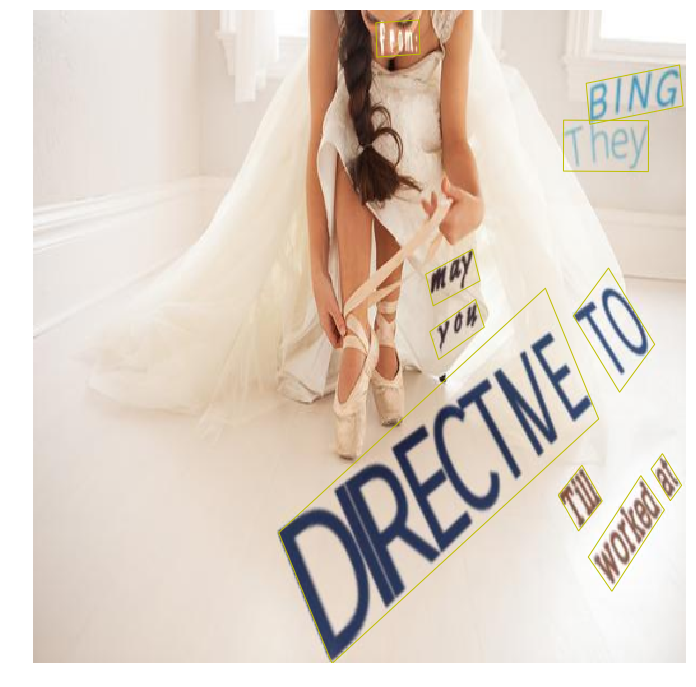

In [12]:
# encoding/decodign ground truth

egt = prior_util.encode(test_gt)
dgt = prior_util.decode(egt, fast_nms=True)
res = dgt
#res = np.unique(res, axis=0)

bbox = res[:,0:4]
quad = res[:,4:12]
rbox = res[:,12:17]
print(bbox)

plt.figure(figsize=[12]*2)
plt.imshow(test_img)
ax = plt.gca()

# ground truth
for j in range(len(test_gt)):
    plot_box(np.reshape(test_gt[j][:8],(-1,2))*512, box_format='polygon', color='y')

for j in range(len(bbox)):
    #break
    #ax.add_patch(plt.Polygon(p, fill=False, edgecolor='r', linewidth=1))
    # bbox
    plot_box(bbox[j]*512, box_format='xyxy', color='b')
    # quardrilaterl
    plot_box(np.reshape(quad[j],(-1,2))*512, box_format='polygon', color='r')
    # rbox
    plot_box(rbox3_to_polygon(rbox[j])*512, box_format='polygon', color='g')
    plt.plot(rbox[j,[0,2]]*512, rbox[j,[1,3]]*512, 'oc')

#prior_util.plot_gt()
#prior_util.plot_results(res)
plt.axis('off')
plt.show()


(76454,)
[[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]]
[[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]]


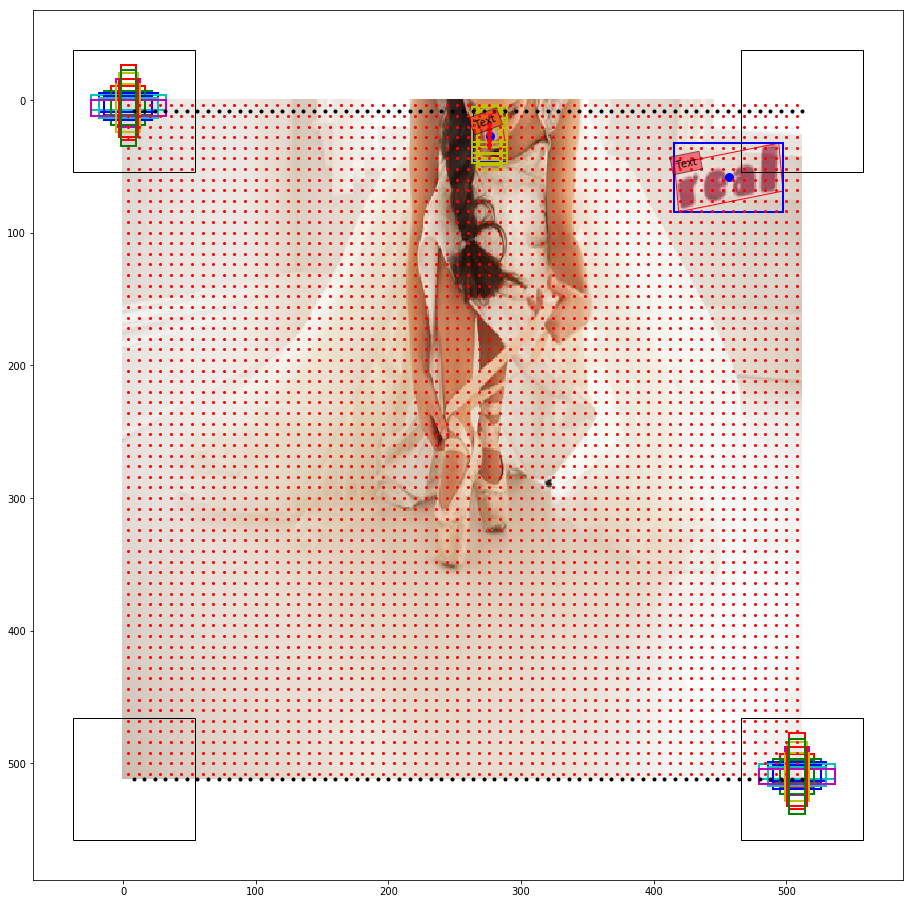

(76454,)
[[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]]
[[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]]


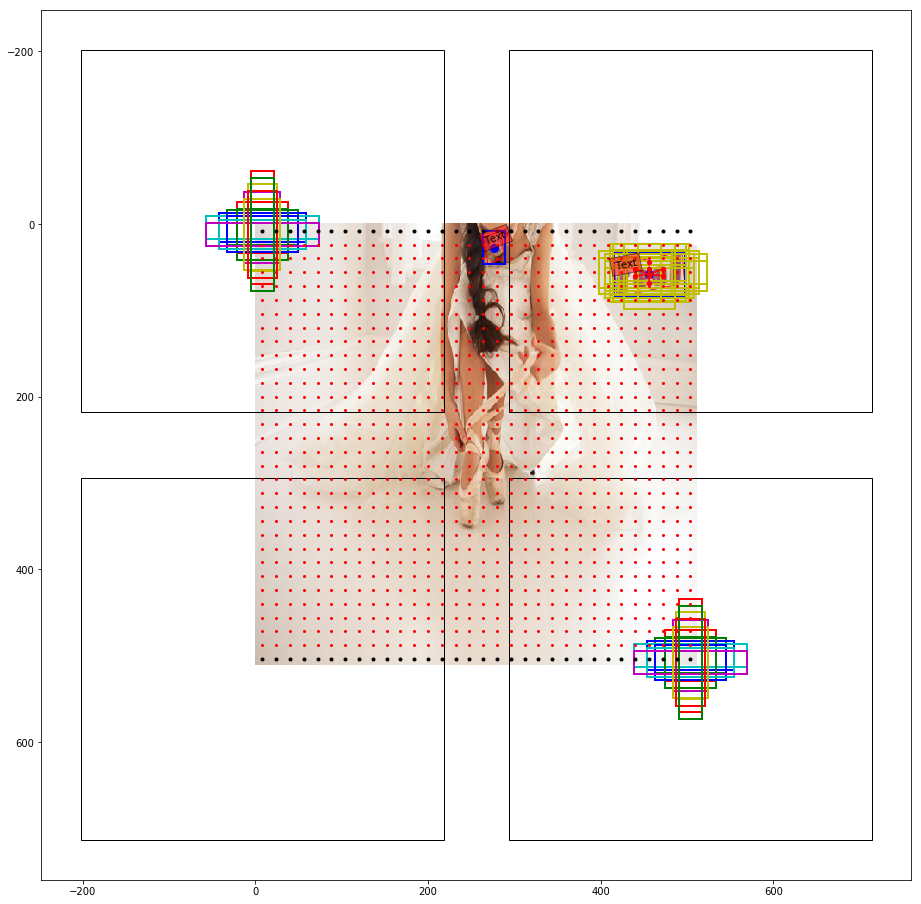

(76454,)
[[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]]
[[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]]


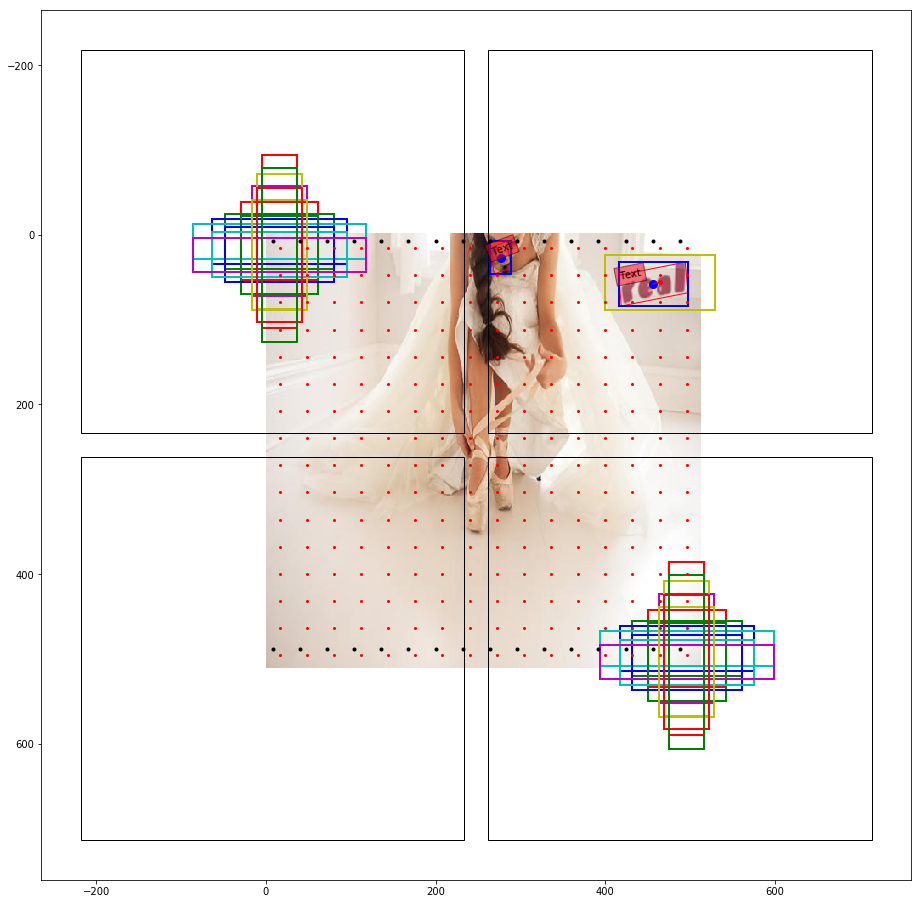

(76454,)
[[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]]
[[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]]


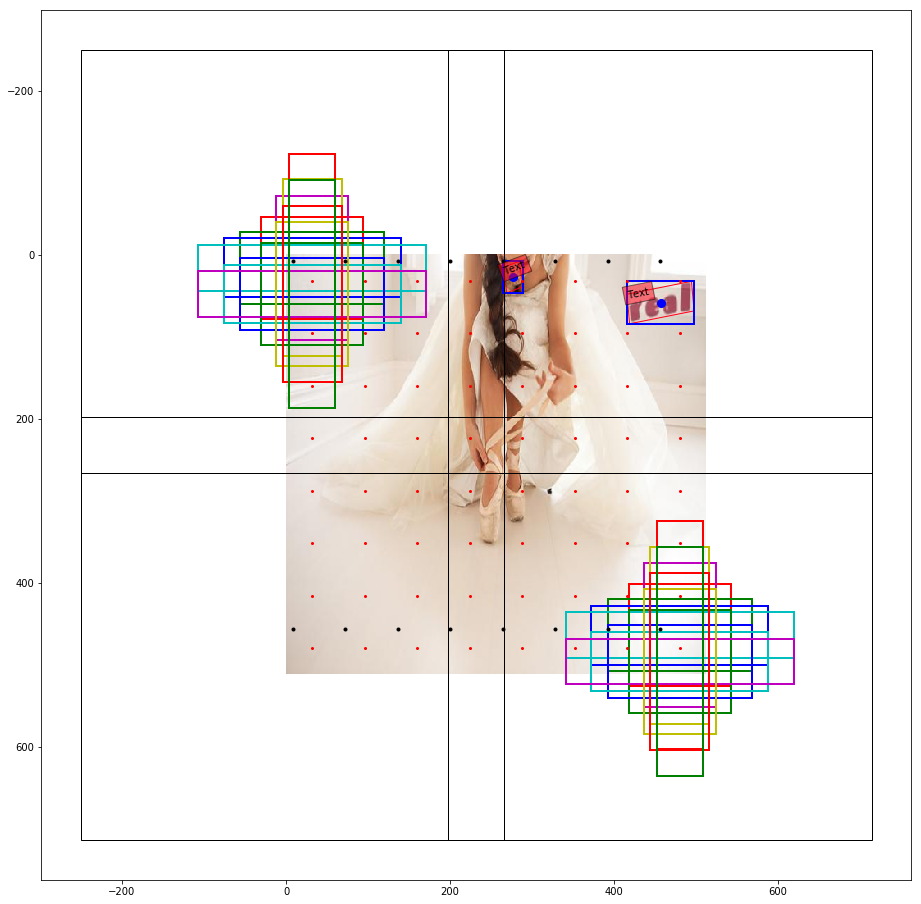

(76454,)
[[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]]
[[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]]


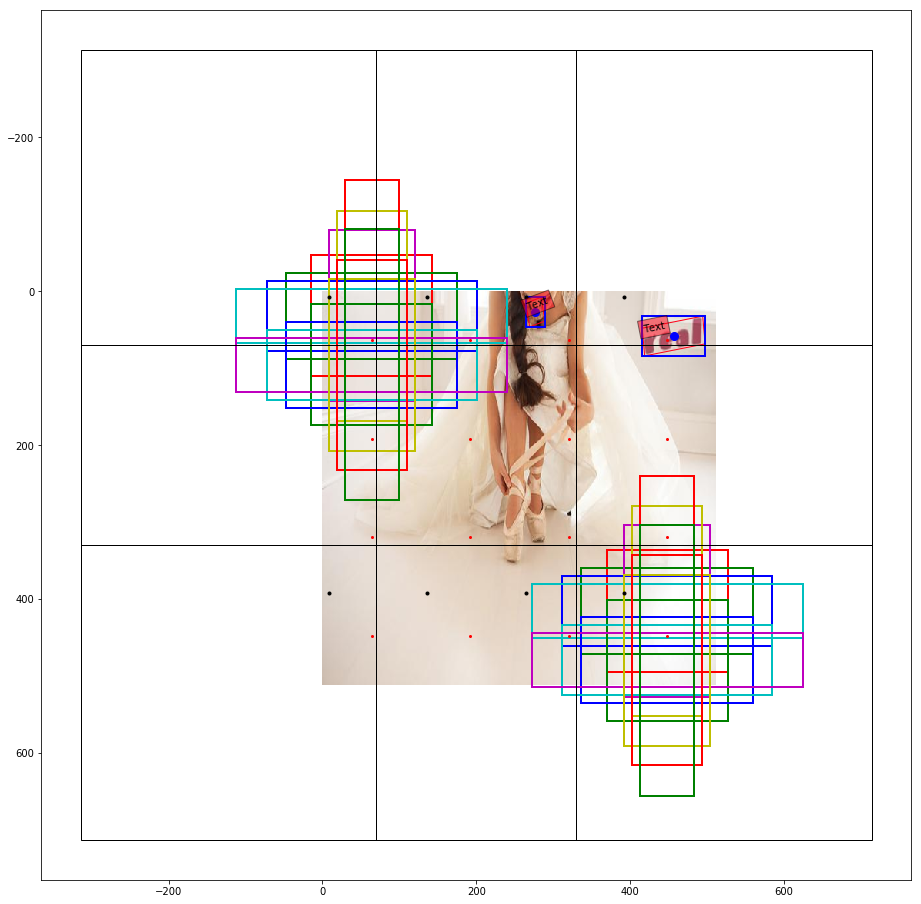

(76454,)
[[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]]
[[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]]


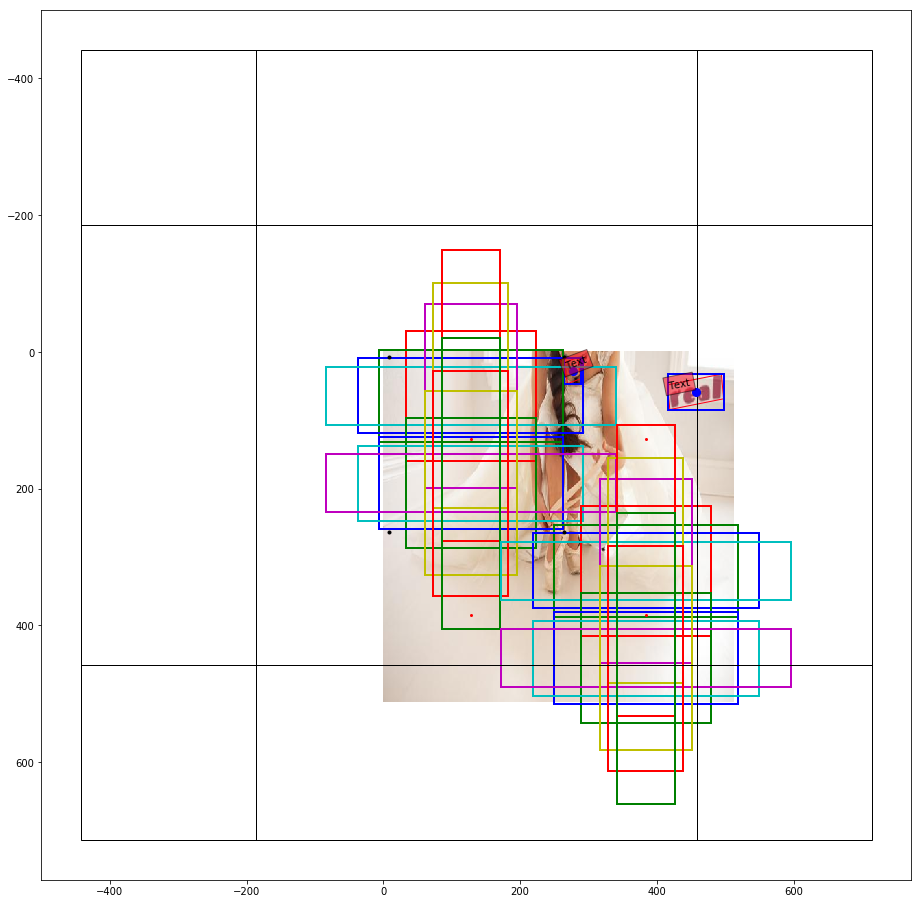

(76454,)
[[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]]
[[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]]


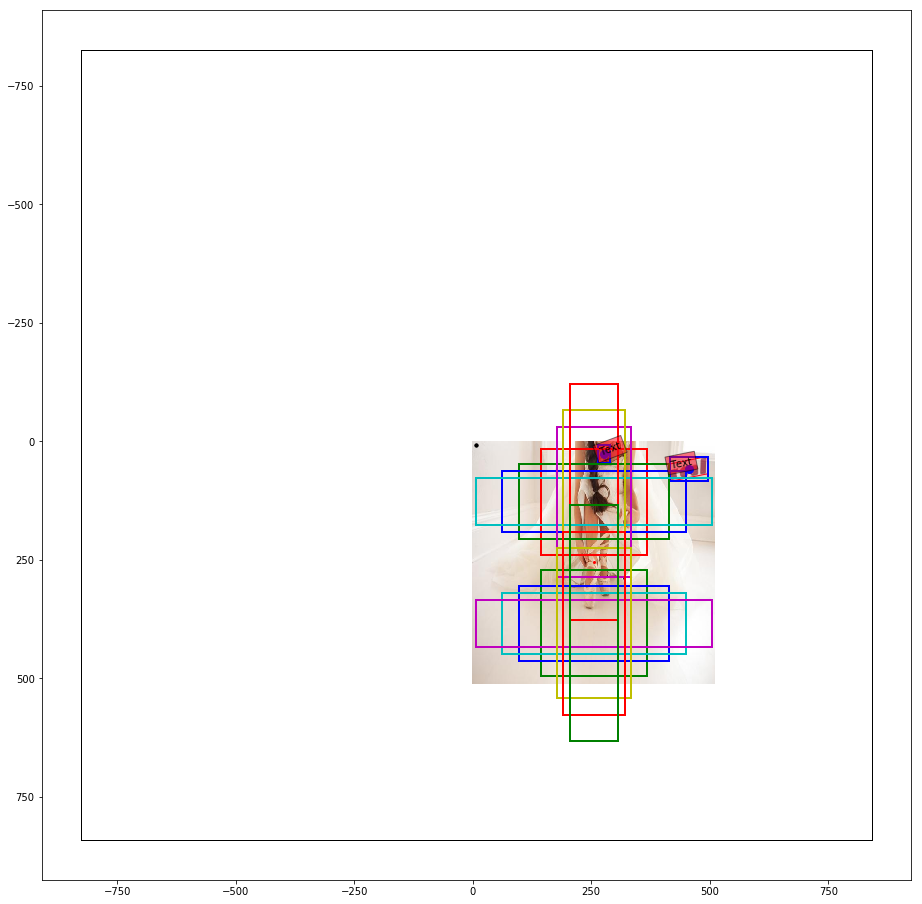

In [13]:
for i in range(len(prior_util.prior_maps)):
    for l in [1]:
        plt.figure(figsize=[16]*2)
        plt.imshow(images[l])
        gt_util.plot_gt(data[l], show_labels=True)
        prior_util.encode(data[l])
        prior_util.plot_assignement(i)
        m = prior_util.prior_maps[i]
        m.plot_locations()
        m.plot_boxes([0,m.map_size[0]*m.map_size[1]-1])
        m.plot_boxes
        
        rf, es, off = calc_receptive_field(model, prior_util.source_layers_names[i], verbose=False)
        off += (8,8)
        #print(off)
        
        for j in [0,m.map_size[0]-1]:
            for k in [0,m.map_size[1]-1]:
                box = np.concatenate([off+es*(j,k)-rf/2, off+es*(j,k)+rf/2])
                plot_box(box, 'xyxy', 'k')
        
        for k in [0, m.map_size[1]-1]:
            xy = [[off+es*(j,k)] for j in range(m.map_size[0])]
            xy = np.vstack(xy)
        
            plt.plot(xy[:,0], xy[:,1], 'k.', markersize=6)
        
        ax = plt.gca()
        #ax.set_xlim([-200, 700])
        #ax.set_ylim([700, -200])
        
        plt.show()

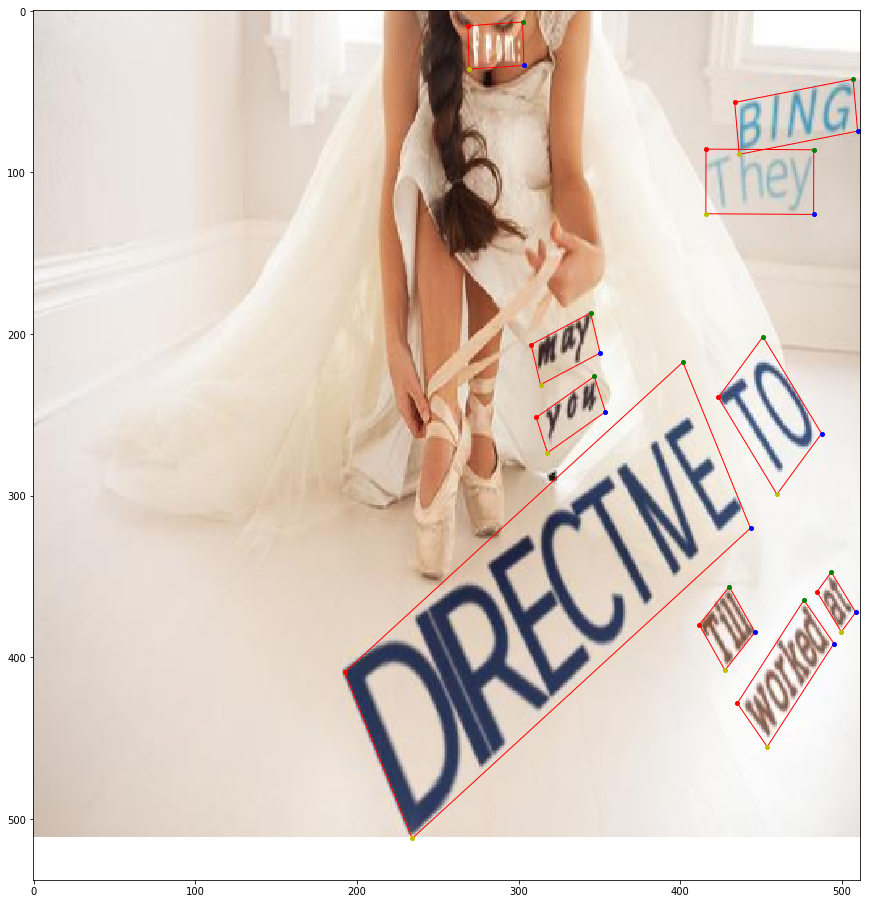

In [14]:
plt.figure(figsize=[16]*2)
plt.imshow(test_img)
#gt_util.plot_gt(test_gt, show_labels=True)
im = plt.gci()
for i in range(len(test_gt)):
    plot_box(test_gt[i,:8], box_format='polygon', normalized=True, vertices=True)
plt.show()

In [15]:
egt = prior_util.encode(test_gt)
res = prior_util.decode(egt, confidence_threshold=0.1, fast_nms=True, keep_top_k=100, sparse=True)

(76454,)
[[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]]
[[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]


In [16]:
np.nonzero(egt[:,-1])

(array([    0,     1,     2, ..., 76451, 76452, 76453]),)

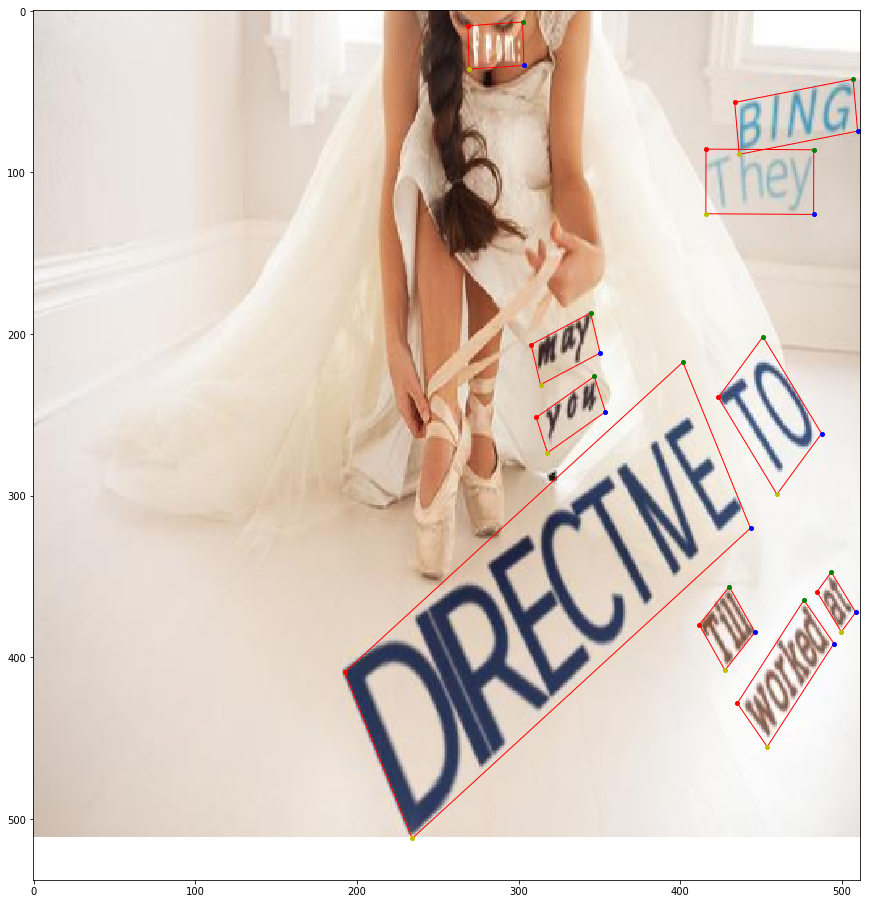

In [17]:
plt.figure(figsize=[16]*2)
plt.imshow(test_img)
#gt_util.plot_gt(test_gt, show_labels=True)
im = plt.gci()

for i in range(len(test_gt)):
    plot_box(test_gt[i,:8], box_format='polygon', normalized=True, vertices=True)

for i in range(len(res)):
    plot_box(res[i,:4], box_format='xyxy', color='b', normalized=True, vertices=True)
    plot_box(res[i,4:12], box_format='polygon', color='g', normalized=True, vertices=True)

for i in range(len(prior_util.prior_maps)):
    #prior_util.plot_assignement(i)
    pass

#m = prior_util.prior_maps[0]
#m.plot_locations()

plt.show()

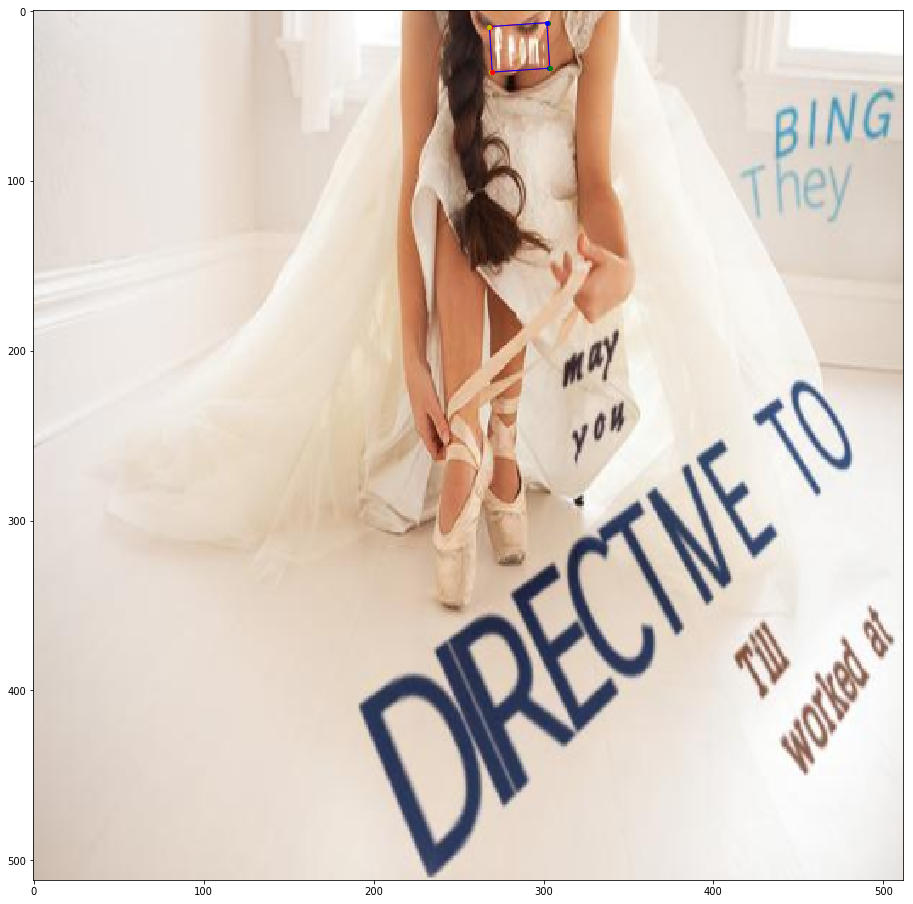

In [18]:
xy = np.reshape(test_gt[0,:8], (-1,2))
p = rbox_to_polygon(polygon_to_rbox(xy))

plt.figure(figsize=[16]*2)
plt.imshow(test_img)
#gt_util.plot_gt(test_gt, show_labels=True)
im = plt.gci()

plot_box(xy.flatten(), box_format='polygon', color='r', normalized=True, vertices=True)

plot_box(p.flatten(), box_format='polygon', color='b', normalized=True, vertices=True)
plt.show()
